In [35]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

In [4]:
# AuraSR: GAN-based Super-Resolution for real-world, a reproduction of the GigaGAN* paper. Implementation is
# based on the unofficial lucidrains/gigagan-pytorch repository. Heavily modified from there.
#
# https://mingukkang.github.io/GigaGAN/
from math import log2, ceil
from functools import partial
from typing import Any, Optional, List, Iterable

import torch
from torchvision import transforms
from PIL import Image
from torch import nn, einsum, Tensor
import torch.nn.functional as F

from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange
from torchvision.utils import save_image
import math


def get_same_padding(size, kernel, dilation, stride):
    return ((size - 1) * (stride - 1) + dilation * (kernel - 1)) // 2


class AdaptiveConv2DMod(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        kernel,
        *,
        demod=True,
        stride=1,
        dilation=1,
        eps=1e-8,
        num_conv_kernels=1,  # set this to be greater than 1 for adaptive
    ):
        super().__init__()
        self.eps = eps

        self.dim_out = dim_out

        self.kernel = kernel
        self.stride = stride
        self.dilation = dilation
        self.adaptive = num_conv_kernels > 1

        self.weights = nn.Parameter(
            torch.randn((num_conv_kernels, dim_out, dim, kernel, kernel))
        )

        self.demod = demod

        nn.init.kaiming_normal_(
            self.weights, a=0, mode="fan_in", nonlinearity="leaky_relu"
        )

    def forward(
        self, fmap, mod: Optional[Tensor] = None, kernel_mod: Optional[Tensor] = None
    ):
        """
        notation

        b - batch
        n - convs
        o - output
        i - input
        k - kernel
        """

        b, h = fmap.shape[0], fmap.shape[-2]

        # account for feature map that has been expanded by the scale in the first dimension
        # due to multiscale inputs and outputs

        if mod.shape[0] != b:
            mod = repeat(mod, "b ... -> (s b) ...", s=b // mod.shape[0])

        if exists(kernel_mod):
            kernel_mod_has_el = kernel_mod.numel() > 0

            assert self.adaptive or not kernel_mod_has_el

            if kernel_mod_has_el and kernel_mod.shape[0] != b:
                kernel_mod = repeat(
                    kernel_mod, "b ... -> (s b) ...", s=b // kernel_mod.shape[0]
                )

        # prepare weights for modulation

        weights = self.weights

        if self.adaptive:
            weights = repeat(weights, "... -> b ...", b=b)

            # determine an adaptive weight and 'select' the kernel to use with softmax

            assert exists(kernel_mod) and kernel_mod.numel() > 0

            kernel_attn = kernel_mod.softmax(dim=-1)
            kernel_attn = rearrange(kernel_attn, "b n -> b n 1 1 1 1")

            weights = reduce(weights * kernel_attn, "b n ... -> b ...", "sum")

        # do the modulation, demodulation, as done in stylegan2

        mod = rearrange(mod, "b i -> b 1 i 1 1")

        weights = weights * (mod + 1)

        if self.demod:
            inv_norm = (
                reduce(weights**2, "b o i k1 k2 -> b o 1 1 1", "sum")
                .clamp(min=self.eps)
                .rsqrt()
            )
            weights = weights * inv_norm

        fmap = rearrange(fmap, "b c h w -> 1 (b c) h w")

        weights = rearrange(weights, "b o ... -> (b o) ...")

        padding = get_same_padding(h, self.kernel, self.dilation, self.stride)
        fmap = F.conv2d(fmap, weights, padding=padding, groups=b)

        return rearrange(fmap, "1 (b o) ... -> b o ...", b=b)


class Attend(nn.Module):
    def __init__(self, dropout=0.0, flash=False):
        super().__init__()
        self.dropout = dropout
        self.attn_dropout = nn.Dropout(dropout)
        self.scale = nn.Parameter(torch.randn(1))
        self.flash = flash

    def flash_attn(self, q, k, v):
        q, k, v = map(lambda t: t.contiguous(), (q, k, v))
        out = F.scaled_dot_product_attention(
            q, k, v, dropout_p=self.dropout if self.training else 0.0
        )
        return out

    def forward(self, q, k, v):
        if self.flash:
            return self.flash_attn(q, k, v)

        scale = q.shape[-1] ** -0.5

        # similarity
        sim = einsum("b h i d, b h j d -> b h i j", q, k) * scale

        # attention
        attn = sim.softmax(dim=-1)
        attn = self.attn_dropout(attn)

        # aggregate values
        out = einsum("b h i j, b h j d -> b h i d", attn, v)

        return out


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


def cast_tuple(t, length=1):
    if isinstance(t, tuple):
        return t
    return (t,) * length


def identity(t, *args, **kwargs):
    return t


def is_power_of_two(n):
    return log2(n).is_integer()


def null_iterator():
    while True:
        yield None

def Downsample(dim, dim_out=None):
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )


class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.eps = 1e-4

    def forward(self, x):
        return F.normalize(x, dim=1) * self.g * (x.shape[1] ** 0.5)


# building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8, num_conv_kernels=0):
        super().__init__()
        self.proj = AdaptiveConv2DMod(
            dim, dim_out, kernel=3, num_conv_kernels=num_conv_kernels
        )
        self.kernel = 3
        self.dilation = 1
        self.stride = 1

        self.act = nn.SiLU()

    def forward(self, x, conv_mods_iter: Optional[Iterable] = None):
        conv_mods_iter = conv_mods_iter

        x = self.proj(x, mod=next(conv_mods_iter), kernel_mod=next(conv_mods_iter))

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    def __init__(
        self, dim, dim_out, *, groups=8, num_conv_kernels=0, style_dims: List = []
    ):
        super().__init__()
        style_dims.extend([dim, num_conv_kernels, dim_out, num_conv_kernels])

        self.block1 = Block(
            dim, dim_out, groups=groups, num_conv_kernels=num_conv_kernels
        )
        self.block2 = Block(
            dim_out, dim_out, groups=groups, num_conv_kernels=num_conv_kernels
        )
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, conv_mods_iter: Optional[Iterable] = None):
        h = self.block1(x, conv_mods_iter=conv_mods_iter)
        h = self.block2(h, conv_mods_iter=conv_mods_iter)

        return h + self.res_conv(x)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.norm = RMSNorm(dim)
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), RMSNorm(dim))

    def forward(self, x):
        b, c, h, w = x.shape

        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale

        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32, flash=False):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads

        self.norm = RMSNorm(dim)

        self.attend = Attend(flash=flash)
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim=1)

        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h (x y) c", h=self.heads), qkv
        )

        out = self.attend(q, k, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)

        return self.to_out(out)


# feedforward
def FeedForward(dim, mult=4):
    return nn.Sequential(
        RMSNorm(dim),
        nn.Conv2d(dim, dim * mult, 1),
        nn.GELU(),
        nn.Conv2d(dim * mult, dim, 1),
    )


# transformers
class Transformer(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8, depth=1, flash_attn=True, ff_mult=4):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        Attention(
                            dim=dim, dim_head=dim_head, heads=heads, flash=flash_attn
                        ),
                        FeedForward(dim=dim, mult=ff_mult),
                    ]
                )
            )

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return x


class LinearTransformer(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8, depth=1, ff_mult=4):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        LinearAttention(dim=dim, dim_head=dim_head, heads=heads),
                        FeedForward(dim=dim, mult=ff_mult),
                    ]
                )
            )

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return x


class NearestNeighborhoodUpsample(nn.Module):
    def __init__(self, dim, dim_out=None):
        super().__init__()
        dim_out = default(dim_out, dim)
        self.conv = nn.Conv2d(dim, dim_out, kernel_size=3, stride=1, padding=1)

    def forward(self, x):

        if x.shape[0] >= 64:
            x = x.contiguous()

        x = F.interpolate(x, scale_factor=2.0, mode="nearest")
        x = self.conv(x)

        return x

class EqualLinear(nn.Module):
    def __init__(self, dim, dim_out, lr_mul=1, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(dim_out, dim))
        if bias:
            self.bias = nn.Parameter(torch.zeros(dim_out))

        self.lr_mul = lr_mul

    def forward(self, input):
        return F.linear(input, self.weight * self.lr_mul, bias=self.bias * self.lr_mul)


class StyleGanNetwork(nn.Module):
    def __init__(self, dim_in=128, dim_out=512, depth=8, lr_mul=0.1, dim_text_latent=0):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dim_text_latent = dim_text_latent

        layers = []
        for i in range(depth):
            is_first = i == 0

            if is_first:
                dim_in_layer = dim_in + dim_text_latent
            else:
                dim_in_layer = dim_out

            dim_out_layer = dim_out

            layers.extend(
                [EqualLinear(dim_in_layer, dim_out_layer, lr_mul), nn.LeakyReLU(0.2)]
            )

        self.net = nn.Sequential(*layers)

    def forward(self, x, text_latent=None):
        x = F.normalize(x, dim=1)
        if self.dim_text_latent > 0:
            assert exists(text_latent)
            x = torch.cat((x, text_latent), dim=-1)
        return self.net(x)


class UnetUpsampler(torch.nn.Module):

    def __init__(
        self,
        dim: int,
        *,
        image_size: int,
        input_image_size: int,
        init_dim: Optional[int] = None,
        out_dim: Optional[int] = None,
        style_network: Optional[dict] = None,
        up_dim_mults: tuple = (1, 2, 4, 8, 16),
        down_dim_mults: tuple = (4, 8, 16),
        channels: int = 3,
        resnet_block_groups: int = 8,
        full_attn: tuple = (False, False, False, True, True),
        flash_attn: bool = True,
        self_attn_dim_head: int = 64,
        self_attn_heads: int = 8,
        attn_depths: tuple = (2, 2, 2, 2, 4),
        mid_attn_depth: int = 4,
        num_conv_kernels: int = 4,
        resize_mode: str = "bilinear",
        unconditional: bool = True,
        skip_connect_scale: Optional[float] = None,
    ):
        super().__init__()
        self.style_network = style_network = StyleGanNetwork(**style_network)
        self.unconditional = unconditional
        assert not (
            unconditional
            and exists(style_network)
            and style_network.dim_text_latent > 0
        )

        assert is_power_of_two(image_size) and is_power_of_two(
            input_image_size
        ), "both output image size and input image size must be power of 2"
        assert (
            input_image_size < image_size
        ), "input image size must be smaller than the output image size, thus upsampling"

        self.image_size = image_size
        self.input_image_size = input_image_size

        style_embed_split_dims = []

        self.channels = channels
        input_channels = channels

        init_dim = default(init_dim, dim)

        up_dims = [init_dim, *map(lambda m: dim * m, up_dim_mults)]
        init_down_dim = up_dims[len(up_dim_mults) - len(down_dim_mults)]
        down_dims = [init_down_dim, *map(lambda m: dim * m, down_dim_mults)]
        self.init_conv = nn.Conv2d(input_channels, init_down_dim, 7, padding=3)

        up_in_out = list(zip(up_dims[:-1], up_dims[1:]))
        down_in_out = list(zip(down_dims[:-1], down_dims[1:]))

        block_klass = partial(
            ResnetBlock,
            groups=resnet_block_groups,
            num_conv_kernels=num_conv_kernels,
            style_dims=style_embed_split_dims,
        )

        FullAttention = partial(Transformer, flash_attn=flash_attn)
        *_, mid_dim = up_dims

        self.skip_connect_scale = default(skip_connect_scale, 2**-0.5)

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])

        block_count = 6

        for ind, (
            (dim_in, dim_out),
            layer_full_attn,
            layer_attn_depth,
        ) in enumerate(zip(down_in_out, full_attn, attn_depths)):
            attn_klass = FullAttention if layer_full_attn else LinearTransformer

            blocks = []
            for i in range(block_count):
                blocks.append(block_klass(dim_in, dim_in))

            self.downs.append(
                nn.ModuleList(
                    [
                        nn.ModuleList(blocks),
                        nn.ModuleList(
                            [
                                (
                                    attn_klass(
                                        dim_in,
                                        dim_head=self_attn_dim_head,
                                        heads=self_attn_heads,
                                        depth=layer_attn_depth,
                                    )
                                    if layer_full_attn
                                    else None
                                ),
                                nn.Conv2d(
                                    dim_in, dim_out, kernel_size=3, stride=2, padding=1
                                ),
                            ]
                        ),
                    ]
                )
            )

        self.mid_block1 = block_klass(mid_dim, mid_dim)
        self.mid_attn = FullAttention(
            mid_dim,
            dim_head=self_attn_dim_head,
            heads=self_attn_heads,
            depth=mid_attn_depth,
        )
        self.mid_block2 = block_klass(mid_dim, mid_dim)

        *_, last_dim = up_dims

        for ind, (
            (dim_in, dim_out),
            layer_full_attn,
            layer_attn_depth,
        ) in enumerate(
            zip(
                reversed(up_in_out),
                reversed(full_attn),
                reversed(attn_depths),
            )
        ):
            attn_klass = FullAttention if layer_full_attn else LinearTransformer

            blocks = []
            input_dim = dim_in * 2 if ind < len(down_in_out) else dim_in
            for i in range(block_count):
                blocks.append(block_klass(input_dim, dim_in))

            self.ups.append(
                nn.ModuleList(
                    [
                        nn.ModuleList(blocks),
                        nn.ModuleList(
                            [
                                NearestNeighborhoodUpsample(
                                    last_dim if ind == 0 else dim_out,
                                    dim_in,
                                ),
                                (
                                    attn_klass(
                                        dim_in,
                                        dim_head=self_attn_dim_head,
                                        heads=self_attn_heads,
                                        depth=layer_attn_depth,
                                    )
                                    if layer_full_attn
                                    else None
                                ),
                            ]
                        ),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)
        self.final_res_block = block_klass(dim, dim)
        self.final_to_rgb = nn.Conv2d(dim, channels, 1)
        self.resize_mode = resize_mode
        self.style_to_conv_modulations = nn.Linear(
            style_network.dim_out, sum(style_embed_split_dims)
        )
        self.style_embed_split_dims = style_embed_split_dims

    @property
    def allowable_rgb_resolutions(self):
        input_res_base = int(log2(self.input_image_size))
        output_res_base = int(log2(self.image_size))
        allowed_rgb_res_base = list(range(input_res_base, output_res_base))
        return [*map(lambda p: 2**p, allowed_rgb_res_base)]

    @property
    def device(self):
        return self.style_network.net[0].weight.device

    @property
    def total_params(self):
        return sum([p.numel() for p in self.parameters()])

    def resize_image_to(self, x, size):
        return F.interpolate(x, (size, size), mode=self.resize_mode)

    def forward(
        self,
        lowres_image: torch.Tensor,
        styles: Optional[torch.Tensor] = None,
        noise: Optional[torch.Tensor] = None,
        global_text_tokens: Optional[torch.Tensor] = None,
        return_all_rgbs: bool = False,
    ):
        x = lowres_image

        noise_scale = 0.001  # Adjust the scale of the noise as needed
        noise_aug = torch.randn_like(x) * noise_scale
        x = x + noise_aug
        x = x.clamp(0, 1)

        shape = x.shape
        batch_size = shape[0]

        assert shape[-2:] == ((self.input_image_size,) * 2)

        # styles
        if not exists(styles):
            assert exists(self.style_network)

            noise = default(
                noise,
                torch.randn(
                    (batch_size, self.style_network.dim_in), device= self.device
                ),
            )
            styles = self.style_network(noise, global_text_tokens)

        # project styles to conv modulations
        conv_mods = self.style_to_conv_modulations(styles)
        conv_mods = conv_mods.split(self.style_embed_split_dims, dim=-1)
        conv_mods = iter(conv_mods)

        x = self.init_conv(x)

        h = []
        for blocks, (attn, downsample) in self.downs:
            for block in blocks:
                x = block(x, conv_mods_iter=conv_mods)
                h.append(x)

            if attn is not None:
                x = attn(x)

            x = downsample(x)

        x = self.mid_block1(x, conv_mods_iter=conv_mods)
        x = self.mid_attn(x)
        x = self.mid_block2(x, conv_mods_iter=conv_mods)

        for (
            blocks,
            (
                upsample,
                attn,
            ),
        ) in self.ups:
            x = upsample(x)
            for block in blocks:
                if h != []:
                    res = h.pop()
                    res = res * self.skip_connect_scale
                    x = torch.cat((x, res), dim=1)

                x = block(x, conv_mods_iter=conv_mods)

            if attn is not None:
                x = attn(x)

        x = self.final_res_block(x, conv_mods_iter=conv_mods)
        rgb = self.final_to_rgb(x)

        if not return_all_rgbs:
            return rgb

        return rgb, []


def tile_image(image, chunk_size=64):
    c, h, w = image.shape
    h_chunks = ceil(h / chunk_size)
    w_chunks = ceil(w / chunk_size)
    tiles = []
    for i in range(h_chunks):
        for j in range(w_chunks):
            tile = image[:, i * chunk_size:(i + 1) * chunk_size, j * chunk_size:(j + 1) * chunk_size]
            tiles.append(tile)
    return tiles, h_chunks, w_chunks

# This helps create a checkboard pattern with some edge blending
def create_checkerboard_weights(tile_size):
    x = torch.linspace(-1, 1, tile_size)
    y = torch.linspace(-1, 1, tile_size)

    x, y = torch.meshgrid(x, y, indexing='ij')
    d = torch.sqrt(x*x + y*y)
    sigma, mu = 0.5, 0.0
    weights = torch.exp(-((d-mu)**2 / (2.0 * sigma**2)))

    # saturate the values to sure get high weights in the center
    weights = weights**8

    return weights / weights.max()  # Normalize to [0, 1]

def repeat_weights(weights, image_size):
    tile_size = weights.shape[0]
    repeats = (math.ceil(image_size[0] / tile_size), math.ceil(image_size[1] / tile_size))
    return weights.repeat(repeats)[:image_size[0], :image_size[1]]

def create_offset_weights(weights, image_size):
    tile_size = weights.shape[0]
    offset = tile_size // 2
    full_weights = repeat_weights(weights, (image_size[0] + offset, image_size[1] + offset))
    return full_weights[offset:, offset:]

def merge_tiles(tiles, h_chunks, w_chunks, chunk_size=64):
    # Determine the shape of the output tensor
    c = tiles[0].shape[0]
    h = h_chunks * chunk_size
    w = w_chunks * chunk_size

    # Create an empty tensor to hold the merged image
    merged = torch.zeros((c, h, w), dtype=tiles[0].dtype)

    # Iterate over the tiles and place them in the correct position
    for idx, tile in enumerate(tiles):
        i = idx // w_chunks
        j = idx % w_chunks

        h_start = i * chunk_size
        w_start = j * chunk_size

        tile_h, tile_w = tile.shape[1:]
        merged[:, h_start:h_start+tile_h, w_start:w_start+tile_w] = tile

    return merged

class AuraSR:
    def __init__(self, config: dict[str, Any], device: str = "cuda"):
        self.upsampler = UnetUpsampler(**config).to(device)
        self.input_image_size = config["input_image_size"]

    @classmethod
    def from_pretrained(cls, model_id: str = "fal-ai/AuraSR", use_safetensors: bool = True, device: str = "cuda"):
        import json
        import torch
        from pathlib import Path
        from huggingface_hub import snapshot_download

        # Check if model_id is a local file
        if Path(model_id).is_file():
            local_file = Path(model_id)
            if local_file.suffix == '.safetensors':
                use_safetensors = True
            elif local_file.suffix == '.ckpt':
                use_safetensors = False
            else:
                raise ValueError(f"Unsupported file format: {local_file.suffix}. Please use .safetensors or .ckpt files.")

            # For local files, we need to provide the config separately
            config_path = local_file.with_name('config.json')
            if not config_path.exists():
                raise FileNotFoundError(
                    f"Config file not found: {config_path}. "
                    f"When loading from a local file, ensure that 'config.json' "
                    f"is present in the same directory as '{local_file.name}'. "
                    f"If you're trying to load a model from Hugging Face, "
                    f"please provide the model ID instead of a file path."
                )

            config = json.loads(config_path.read_text())
            hf_model_path = local_file.parent
        else:
            hf_model_path = Path(snapshot_download(model_id))
            config = json.loads((hf_model_path / "config.json").read_text())

        model = cls(config, device)

        if use_safetensors:
            try:
                from safetensors.torch import load_file
                checkpoint = load_file(hf_model_path / "model.safetensors" if not Path(model_id).is_file() else model_id)
            except ImportError:
                raise ImportError(
                    "The safetensors library is not installed. "
                    "Please install it with `pip install safetensors` "
                    "or use `use_safetensors=False` to load the model with PyTorch."
                )
        else:
            checkpoint = torch.load(hf_model_path / "model.ckpt" if not Path(model_id).is_file() else model_id)

        model.upsampler.load_state_dict(checkpoint, strict=True)
        return model

    @torch.no_grad()
    def upscale_4x(self, image: Image.Image, max_batch_size=8) -> Image.Image:
        tensor_transform = transforms.ToTensor()
        device = self.upsampler.device

        image_tensor = tensor_transform(image).unsqueeze(0)
        _, _, h, w = image_tensor.shape
        pad_h = (self.input_image_size - h % self.input_image_size) % self.input_image_size
        pad_w = (self.input_image_size - w % self.input_image_size) % self.input_image_size

        # Pad the image
        image_tensor = torch.nn.functional.pad(image_tensor, (0, pad_w, 0, pad_h), mode='reflect').squeeze(0)
        tiles, h_chunks, w_chunks = tile_image(image_tensor, self.input_image_size)

        # Batch processing of tiles
        num_tiles = len(tiles)
        batches = [tiles[i:i + max_batch_size] for i in range(0, num_tiles, max_batch_size)]
        reconstructed_tiles = []

        for batch in batches:
            model_input = torch.stack(batch).to(device)
            generator_output = self.upsampler(
                lowres_image=model_input,
                noise=torch.randn(model_input.shape[0], 128, device=device)
            )
            reconstructed_tiles.extend(list(generator_output.clamp_(0, 1).detach().cpu()))

        merged_tensor = merge_tiles(reconstructed_tiles, h_chunks, w_chunks, self.input_image_size * 4)
        unpadded = merged_tensor[:, :h * 4, :w * 4]

        to_pil = transforms.ToPILImage()
        return to_pil(unpadded)
    # Tiled 4x upscaling with overlapping tiles to reduce seam artifacts
    # weights options are 'checkboard' and 'constant'
    @torch.no_grad()
    def upscale_4x_overlapped(self, image, max_batch_size=16, weight_type='checkboard'):
        tensor_transform = transforms.ToTensor()
        device = self.upsampler.device

        image_tensor = tensor_transform(image).unsqueeze(0)
        _, _, h, w = image_tensor.shape

        # Calculate paddings
        pad_h = (
            self.input_image_size - h % self.input_image_size
        ) % self.input_image_size
        pad_w = (
            self.input_image_size - w % self.input_image_size
        ) % self.input_image_size

        pad_h = min(pad_h-1, self.input_image_size-1)
        pad_w = min(pad_w-1, self.input_image_size-1)
        # Pad the image
        image_tensor = torch.nn.functional.pad(
            image_tensor, (0, pad_w, 0, pad_h), mode="reflect"
        ).squeeze(0)

        # Function to process tiles
        def process_tiles(tiles, h_chunks, w_chunks):
            num_tiles = len(tiles)
            batches = [
                tiles[i : i + max_batch_size]
                for i in range(0, num_tiles, max_batch_size)
            ]
            reconstructed_tiles = []

            for batch in batches:
                model_input = torch.stack(batch).to(device)
                generator_output = self.upsampler(
                    lowres_image=model_input,
                    noise=torch.randn(model_input.shape[0], 128, device=device),
                )
                reconstructed_tiles.extend(
                    list(generator_output.clamp_(0, 1).detach().cpu())
                )

            return merge_tiles(
                reconstructed_tiles, h_chunks, w_chunks, self.input_image_size
            )

        # First pass
        tiles1, h_chunks1, w_chunks1 = tile_image(image_tensor, self.input_image_size)
        result1 = process_tiles(tiles1, h_chunks1, w_chunks1)

        # Second pass with offset
        offset = self.input_image_size // 2
        image_tensor_offset = torch.nn.functional.pad(image_tensor, (offset, offset, offset, offset), mode='reflect').squeeze(0)

        tiles2, h_chunks2, w_chunks2 = tile_image(
            image_tensor_offset, self.input_image_size
        )
        result2 = process_tiles(tiles2, h_chunks2, w_chunks2)

        # unpad
        offset_4x = offset * 1
        result2_interior = result2[:, offset_4x:-offset_4x, offset_4x:-offset_4x]

        if weight_type == 'checkboard':
            weight_tile = create_checkerboard_weights(self.input_image_size * 1)

            weight_shape = result2_interior.shape[1:]
            weights_1 = create_offset_weights(weight_tile, weight_shape)
            weights_2 = repeat_weights(weight_tile, weight_shape)

            normalizer = weights_1 + weights_2
            weights_1 = weights_1 / normalizer
            weights_2 = weights_2 / normalizer

            weights_1 = weights_1.unsqueeze(0).repeat(3, 1, 1)
            weights_2 = weights_2.unsqueeze(0).repeat(3, 1, 1)
        elif weight_type == 'constant':
            weights_1 = torch.ones_like(result2_interior) * 0.5
            weights_2 = weights_1
        else:
            raise ValueError("weight_type should be either 'gaussian' or 'constant' but got", weight_type)

        result1 = result1 * weights_2
        result2 = result2_interior * weights_1

        # Average the overlapping region
        result1 = (
            result1 + result2
        )

        # Remove padding
        unpadded = result1[:, : h, : w]

        to_pil = transforms.ToPILImage()
        return to_pil(unpadded)

In [3]:
# !pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.0 MB/s eta 0:00:00


In [ ]:
import requests
from io import BytesIO
from PIL import Image
import os
import cv2
from PIL import Image
import numpy as np

In [5]:
aura_sr = AuraSR.from_pretrained()

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/983 [00:00<?, ?B/s]

LICENSE.md:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

In [6]:
def load_image_from_url(url):
    response = requests.get(url)
    image_data = BytesIO(response.content)
    return Image.open(image_data)

In [7]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

In [44]:
data_path = './'
cifar10 =  CIFAR10(data_path, train=True, download=True)

Files already downloaded and verified

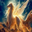

In [42]:
image = image.resize((32,32))
image

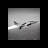

In [49]:
from PIL import Image

# Load your 32x32 image (replace with your image path)
# image = Image.new("RGB", (32, 32), color="red")  # Example red image

# Calculate padding
pad_size = (48 - 32) // 2  # 8 pixels on each side

# Add padding
padded_image = Image.new("RGB", (48, 48), color=(0, 0, 0))  # Black padding
padded_image.paste(image, (pad_size, pad_size))  # Paste the original image centered

# Show the padded image
padded_image


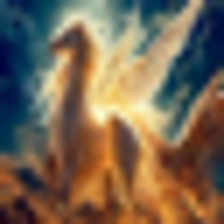

In [22]:
image.resize((224,224), Image.BICUBIC)

In [ ]:
from PIL import Image
import cv2
image = cv2.imread("/kaggle/input/pegasus/Screenshot 2024-11-24 161819.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
# img = Image("/kaggle/input/pegasus/Screenshot 2024-11-24 161819.png")
image

In [55]:
# import matplotlib.pyplot as plt
# for i in range(len(cifar10)):
#   img, label = cifar10[i]
upscaled_image = aura_sr.upscale_4x(padded_image)
upscaled_image = aura_sr.upscale_4x(upscaled_image)
upscaled_image
# upscaled_image = cv2.resize(np.array(upscaled_image), (32,32), interpolation=cv2.INTER_CUBIC)
# cv2.imwrite("pegasus_aursr.png", upscaled_image)
# Image.save("pegasus_aursr", upscaled_image)
upscaled_image.save("pegasus_aursr.png")
  # if i%100 == 0:
  #   print(i)